# **Exploring Self-supervised Learning using (Value Imputation and Mask Estimation)**

`Yoon, J., Zhang, Y., Jordon, J. and van der Schaar, M., 2020. VIME: Extending the Success of Self-and Semi-supervised Learning to Tabular Domain. Advances in Neural Information Processing Systems, 33.`

Existing self- and semi-supervised learning algorithms are not effective for tabular data because they heavily rely on the spatial or semantic structure of image or language data. 

Standard self-supervised leaning framework designs a (set of) pretext task(s) to learn informative representations from the raw input features.

"In this [paper](https://vanderschaar-lab.com/papers/NeurIPS2020_VIME.pdf), we propose novel self- and semi-supervised learning frameworks for tabular data. For self-supervised learning, we introduce a novel pretext task, mask vector estimation in addition to feature vector estimation. To solve those pretext tasks, an encoder function learns to construct informative representations from the raw features in the unlabeled data. 

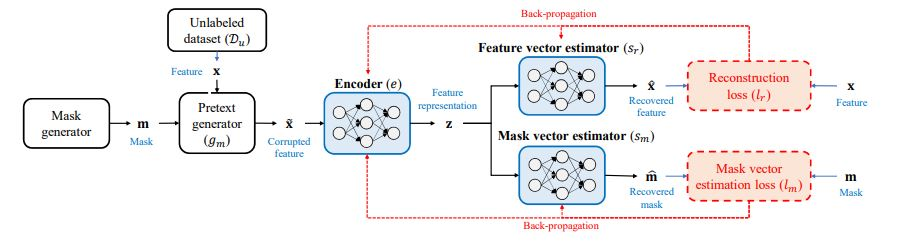

For semi-supervised
learning, we introduce a novel tabular data augmentation scheme. We use the trained encoder to generate multiple augmented samples for each data point by masking each point using several different masks and then imputing the corrupted values for each masked data point. 

Finally, we propose a systematic self- and semi-supervised learning framework for tabular data, VIME (Value Imputation and Mask Estimation), that combines our ideas to produce state-of-the-art performances on several tabular datasets with a few labeled samples, from various domains"




In [1]:
#importing libraries
import numpy as np
import scipy.stats
import scipy.special
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid
from keras.models import Sequential
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
import pickle
import csv
import collections
from datetime import datetime
from sklearn import preprocessing
from keras.callbacks import ModelCheckpoint
import xgboost as xgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix
import math
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import graphviz
from sklearn.calibration import calibration_curve

from itertools import product
from collections import OrderedDict

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# **Kaggle Dataset Loading**

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle kernels list — user Sakzsee — sort-by dateRun

!kaggle competitions download -c higgs-boson

!unzip -q train.csv.zip -d .
!unzip -q test.csv.zip -d .
!ls

kaggle.json
usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: unrecognized arguments: — user Sakzsee — sort-by dateRun
test.zip: Skipping, found more recently modified local copy (use --force to force download)
random_submission.zip: Skipping, found more recently modified local copy (use --force to force download)
HiggsBosonCompetition_AMSMetric_rev1.py: Skipping, found more recently modified local copy (use --force to force download)
training.zip: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open train.csv.zip, train.csv.zip.zip or train.csv.zip.ZIP.
unzip:  cannot find or open test.csv.zip, test.csv.zip.zip or test.csv.zip.ZIP.
HiggsBosonCompetition_AMSMetric_rev1.py  random_submission.zip	test.zip
kaggle.json				 sample_data		training.zip


In [3]:
#Loading train set and loading test set
train = pd.read_csv("training.zip")
test = pd.read_csv("test.zip")

#EventID is identifier - making it an index in both the sets
train.drop('EventId',axis=1,inplace = True)
test.drop('EventId',axis=1,inplace=True)

In [4]:
#one hot encoding our label
train['Label'] = train['Label'].apply(lambda x: 1  if x == 's' else 0)

#Setting up X and Y
X = train.drop(['Label','Weight'], axis = 1)
y = train['Label']

In [5]:
#List to store the features with high correlation as tuples
feat=[]
#Setting a threshold of 0.9 of correlation
threshold=0.9
correlation=X.corr()
for i in X.columns:
    temp=correlation[i]
    #Finding the correlated features greater than the threshold
    corr_features=temp[(abs(temp)>threshold) & (temp.index!=i)].index.values
    #Adding the correlated features into a list keeping in mind that there is only one occurrence of the feature combination
    if(len(corr_features)!=0):
        for j in corr_features:
            features=(i,j)
        
            if(len(feat)==0):
                feat.append(features)
            else:
                count=len(feat)
                for x in feat:
                    if set(x) != set(features):
                        count-=1  
                    else:
                        break
                if(count==0):
                    feat.append(features)
                #[feat.append(features) for x in feat if not (set(x)==set(features))]

## **Removing highly correlated features**

In [6]:
count = {}
for i, j in feat:
    if i in count.keys():
        count[i]+= 1
    else:
        count[i] = 1
    if j in count.keys():
        count[j]+= 1
    else:
        count[j] = 1
for k, v in count.items():
    if v > 2:
        X.drop(k, axis = 1, inplace = True)

# **Scaling Data**

In [7]:
#Scaling data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **Handling Class Imbalance with SMOTE**

In [8]:
import collections
counter = collections.Counter(y)
print('Before', counter)

smt = SMOTE()

#oversampling using SMOTE
X_sm, y_sm = smt.fit_resample(X_scaled,y)

counter = collections.Counter(y_sm)
print('After', counter)

#Creating a Resampled Dataframe
X_sm_df = pd.DataFrame(X_sm, columns=X.columns)
y_sm_df = pd.DataFrame(y_sm, columns = ['Label'])

Before Counter({0: 164333, 1: 85667})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After Counter({1: 164333, 0: 164333})


## **Self-supervised learning in Tabular Domain using VIME**

Yoong et. al propose a new pretext task: to recover the mask vector, in addition to the original sample with a novel corrupted sample generation scheme. 

Also, they propose a novel tabular data augmentation scheme that can be combined with various contrastive learning frameworks to extend the self-supervised learning to tabular domains.

In general, self-supervised learning constructs an
encoder function e : X → Z that takes a sample x ∈ X and returns an informative representation z = e(x) ∈ Z. The representation z is optimized to solve a pretext task defined with a pseudo-label ys ∈ Ys and a self-supervised loss function ls.

In [9]:
#Setting Initial hyperparameters
# Experimental parameters
label_no = 1000  
model_sets = ['logit','xgboost','mlp']
  
# Hyper-parameters
p_m = 0.3
alpha = 0.01
K = 4
beta = 1.0
label_data_rate = 0.6

# Metric
metric = 'acc'
  
# Define output
results = np.zeros([len(model_sets)+2])  

### **Splitting into unlabelled data and defining Utility functions**

In [10]:
#Splitting X and y into train and test 
X_train, X_test, y_train, y_test = train_test_split(X_sm_df, y_sm_df, train_size=0.7, random_state=123)

y_train = np.array(y_train)
y_test = np.array(y_test)

#Spillting into unlabelled and labelled
idx = np.random.permutation(len(y_train))

# Label data : Unlabeled data = label_data_rate:(1-label_data_rate)
label_idx = idx[:int(len(idx)*label_data_rate)]
unlab_idx = idx[int(len(idx)*label_data_rate):]

# Unlabeled data
x_unlab = X_train.iloc[unlab_idx, :]

# Labeled data
x_train = X_train.iloc[label_idx, :]  
y_train = [y_train[i] for i in y_train]

### **Defining our Mask Generator**

In our framework, the two pretext tasks share a single pretext distribution pXs,Ys. First, a mask vector generator outputs a binary mask vector m = [m1, ..., md]> ∈ {0, 1} where mj is randomly sampled from a Bernoulli distribution with probability pm (i.e. pm = Qd j=1 Bern(mj |pm)). Then a pretext generator gm : X × {0, 1} d → X takes a sample x from Du and a mask vector m as input, and generates a masked sample ˜x. The generating process of ˜x is given by:

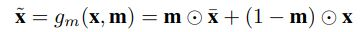


In [11]:
#Mask Generator
def mask_generator (p_m, x):
    mask = np.random.binomial(1, p_m, x.shape)
    return mask

### **Defining our Pre-text Generator**

Following the convention of self-supervised learning, the encoder e first transforms the masked and
corrupted sample ˜x to a representation z, then a pretext predictive model will be introduced to recover
the original sample x from z. Arguably, this is a more challenging task than existing pretext tasks,
such as correcting the rotation of images or recolorizing a grayscale image. A rotated or grayscale
image still contains some information about the original features. In contrast, masking completely
removes some of the features from x and replaces them with a noise sample ¯x of which each feature
may come from a different random sample in Du. The resulting sample ˜x may not contain any
information about the missing features and even hard to identify which features are missing. To solve
such a challenging task, we first divide it into two sub-tasks (pretext tasks):
+ (1) Mask vector estimation: predict which features have been masked;
+ (2) Feature vector estimation: predict the values of the features that have been corrupt

In [12]:
#Pre-text Generator
def pretext_generator (m, x):  
    """Generate corrupted samples.

    Args:
    m: mask matrix
    x: feature matrix

    Returns:
    m_new: final mask matrix after corruption
    x_tilde: corrupted feature matrix
    """

    # Parameters
    no, dim = x.shape  
    
    # Randomly (and column-wise) shuffle data
    x_bar = np.zeros([no, dim])
    
    for i in range(dim):
        idx = np.random.permutation(no)
        x_bar[:, i] = x.iloc[idx, i]

    # Corrupt samples
    x_tilde = x * (1-m) + x_bar * m  
    
    # Define new mask matrix
    m_new = 1 * (x != x_tilde)

    return m_new, x_tilde

In [13]:
#MLP
def mlp(x_train, y_train, x_test, parameters): 

    y_train = np.array(y_train)

    # Convert labels into proper format
    if len(y_train.shape) == 1:
        no = len(y_train)
        dim = len(np.unique(y_train))

        # Define output
        matrix = np.zeros([no,dim])

        # Convert vector to matrix
        for i in range(dim):
            idx = np.where(y_train == i)
            matrix[idx, i] = 1

        y_train = matrix

    # Divide training and validation sets (9:1)
    idx = np.random.permutation(len(x_train[:, 0]))
    train_idx = idx[:int(len(idx)*0.9)]
    valid_idx = idx[int(len(idx)*0.9):]

    # Validation set
    x_valid = x_train[valid_idx, :]
    y_valid = y_train[valid_idx, :]

    # Training set
    x_train = x_train[train_idx, :]
    y_train = y_train[train_idx, :]  

    # Define network parameters
    hidden_dim = parameters['hidden_dim']
    epochs_size = parameters['epochs']
    act_fn = parameters['activation']
    batch_size = parameters['batch_size']

    # Define basic parameters
    data_dim = len(x_train[0, :])
    label_dim = len(y_train[0, :])

    # Build model
    model = Sequential()
    model.add(Dense(hidden_dim, input_dim = data_dim, activation = act_fn))
    model.add(Dense(hidden_dim, activation = act_fn))
    model.add(Dense(label_dim, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer='adam', 
                metrics = ['acc'])

    es = EarlyStopping(monitor='val_loss', mode = 'min', 
                     verbose = 1, restore_best_weights=True, patience=50)

    # Fit model on training dataset
    history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
            epochs = epochs_size, batch_size = batch_size, 
            verbose = 0, callbacks=[es])

    # Predict on x_test
    y_test_hat = model.predict(x_test)
    
    return y_test_hat, history, model

## **Defining our Encoder**

* These two loss functions share the encoder e. It is the only part
we will utilize in the downstream tasks. 

* To understand how the encoder is going to benefit these
downstream tasks, we consider what the encoder must be able to do to solve our pretext tasks. 

* We
make the following intuitive observation: it is important for e to capture the correlation among the
features of x and output some latent representations z that can recover x. In this case, sm can identify
the masked features from the inconsistency between feature values, and sr can impute the masked
features by learning from the correlated non-masked features. For instance, if the value of a feature is
very different from its correlated features, this feature is likely masked and corrupted. 

* We note that
correlations are also learned in other self-supervised learning frameworks, e.g. spatial correlations in
rotated images and autocorrelations between future and previous words. Our framework is novel in
learning the correlations for tabular data whose correlation structure is less obvious than in images or
language. 

* The learned representation that captures the correlation across different parts of the object,
regardless of the object type (e.g. language, image or tabular data), is an informative input for the
various downstream tasks.

In [14]:
#Encoder

# Parameters
_, dim = x_unlab.shape
epochs = 30
batch_size = 128

# Build model  
inputs = Input(shape=(dim,))

# Encoder  
h = Dense(int(dim), activation='relu')(inputs)  

# Mask estimator
output_1 = Dense(dim, activation='sigmoid', name = 'mask')(h)  

# Feature estimator
output_2 = Dense(dim, activation='sigmoid', name = 'feature')(h)

model = Model(inputs = inputs, outputs = [output_1, output_2])

model.compile(optimizer='adam',
            loss={'mask': 'binary_crossentropy', 
                  'feature': 'mean_squared_error'},
            loss_weights={'mask':1, 'feature':alpha})

# Generate corrupted samples
m_unlab = mask_generator(p_m, x_unlab)
m_label, x_tilde = pretext_generator(m_unlab, x_unlab)

# Fit model on unlabeled data
encoder_history = model.fit(x_tilde, {'mask': m_label, 'feature': x_unlab}, 
        epochs = epochs, batch_size= batch_size)

# Extract encoder part
layer_name = model.layers[1].name
layer_output = model.get_layer(layer_name).output
encoder = models.Model(inputs=model.input, outputs=layer_output)

Epoch 1/30
719/719 [==============================] - 3s 3ms/step - loss: 0.6506 - mask_loss: 0.6404 - feature_loss: 1.0196
Epoch 2/30
719/719 [==============================] - 3s 3ms/step - loss: 0.5881 - mask_loss: 0.5799 - feature_loss: 0.8217
Epoch 3/30
719/719 [==============================] - 2s 3ms/step - loss: 0.5696 - mask_loss: 0.5614 - feature_loss: 0.8214
Epoch 4/30
719/719 [==============================] - 3s 3ms/step - loss: 0.5581 - mask_loss: 0.5498 - feature_loss: 0.8319
Epoch 5/30
719/719 [==============================] - 2s 3ms/step - loss: 0.5518 - mask_loss: 0.5437 - feature_loss: 0.8126
Epoch 6/30
719/719 [==============================] - 2s 3ms/step - loss: 0.5482 - mask_loss: 0.5400 - feature_loss: 0.8181
Epoch 7/30
719/719 [==============================] - 2s 3ms/step - loss: 0.5447 - mask_loss: 0.5366 - feature_loss: 0.8101
Epoch 8/30
719/719 [==============================] - 2s 3ms/step - loss: 0.5436 - mask_loss: 0.5354 - feature_loss: 0.8173
Epoch 9/

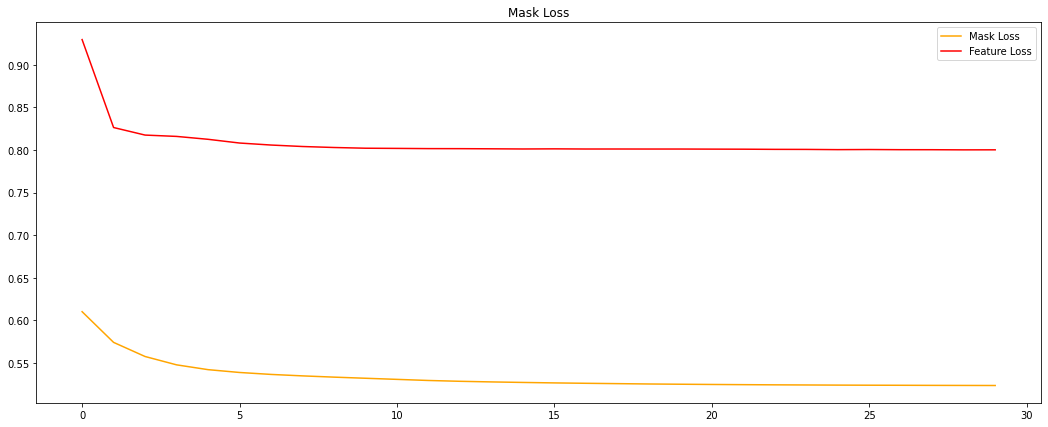

In [15]:
plt.figure(figsize=(18,7))
# plot loss
plt.title('Mask Loss')
plt.plot(encoder_history.history['mask_loss'], color='orange', label='Mask Loss')
plt.plot(encoder_history.history['feature_loss'], color='red', label='Feature Loss')
plt.legend();

In [16]:
mlp_parameters = dict()
mlp_parameters['hidden_dim'] = 256
mlp_parameters['epochs'] = 100
mlp_parameters['activation'] = 'sigmoid'
mlp_parameters['batch_size'] = 128

x_train_hat = encoder.predict(X_train)
x_test_hat = encoder.predict(X_test)

y_test_hat, MLP_history, mlp = mlp(x_train_hat, y_train, x_test_hat, mlp_parameters)

In [17]:
#Viewing the summary of the MLP Model
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               6144      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 72,193
Trainable params: 72,193
Non-trainable params: 0
_________________________________________________________________


In [18]:
#evaluation of our MLP model to see the effectiveness of the Self supervised method
mlp.evaluate(X_test,y_test)

3082/3082 [==============================] - 8s 2ms/step - loss: 12.3694 - acc: 0.4991


[12.369388580322266, 0.4991277754306793]

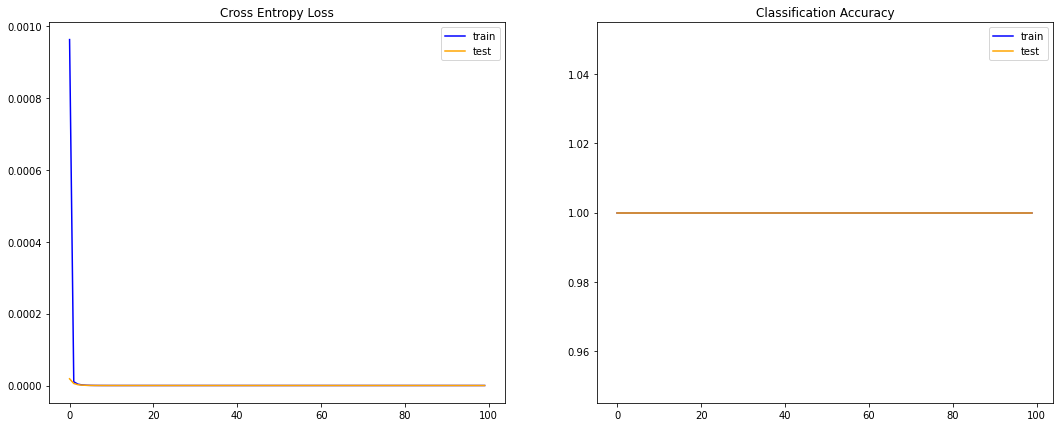

In [20]:
plt.figure(figsize=(18,7))
# plot loss
plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(MLP_history.history['loss'], color='blue', label='train')
plt.plot(MLP_history.history['val_loss'], color='orange', label='test')
plt.legend()

# plot accuracy
plt.subplot(122)
plt.title('Classification Accuracy')
plt.plot(MLP_history.history['acc'], color='blue', label='train')
plt.plot(MLP_history.history['val_acc'], color='orange', label='test')
plt.legend();

# **Conclusion and future work**

Unfortunately the current model does not seem to be working well on our data set. 

Our next steps would be to further preprocess our model and find our different pre-text tasks for the given problem to best understand representations of the Higgs Boson classification Problem Statement.

Pre-text tasks form an important part of any self supervised algorithm. Hence, understanding which pre-text task allows for best representation of our current dataset would be very fruitful. 

We hope to further work on this and find the best way of learning representations.